# Monroe County Housing Affordability

## 1.  Load housing affordability data from HUD Location Affordability dataset.

In previous housing studies, one of the primary sources for data regarding the cost of housing and the economic situations for individuals in the United States has been the American Community Survey (ACS) which is part of the US Census and is one of the most rigorous and broad based attempt to capture this type of information and make it available to the general public. In this analysis we will examine what data is available pertinent to the question of affordable housing and try to understand what this can tell us about the affordability question for the city of Bloomington and greater Monroe county.

**About the Data**
	
The ACS is updated regularly and the data that was used in this analysis was from 2021. ACS data is aggregated either in 1-year estimates or 5-year estimates. This means that the data used to populate the tables is an average over either a 1-year period or a 5-year period. For this project we felt that going with the 5-year estimates would give a better overall understanding of the housing situation, but in the future, it may be useful to update the data with 1 year estimates as they tend to be more current and would be reflective of potential changes as the city implements policies and seeks to measure change. The dataset that we started with was actually hosted and compiled by the Department of Housing and Urban Development which utilized ACS data to build the dataset. More info on HUD Housing Affordability Index can be found here: https://hudgis-hud.opendata.arcgis.com/datasets/HUD::location-affordability-index-v-3/about.


In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset downloadable from (filtered for IN only) : https://hudgis-hud.opendata.arcgis.com/datasets/location-affordability-index-v-3/explore?location=14.179009%2C0.315564%2C2.33
# for data and methodology info: https://files.hudexchange.info/resources/documents/Location-Affordability-Index-Version-3-Data-and-Methodology.pdf

data = gpd.read_file("Location_Affordability_Index_v.3.geojson")  
data.crs
print(type(data))


<class 'geopandas.geodataframe.GeoDataFrame'>


In [3]:
# del subdata

# Indiana state code: 18, Monroe count: 105
subdata = data.loc[data['STATE']== '18']
print(subdata.shape)

(1508, 445)


Below we select the columns that are interesting for our purposes. For more information on the columns see the data dictionary below.

In [4]:
# for FIPS code info: https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code
# Indiana state code: 18, Monroe county: 105
def state_data(state_fips):
    subdata = data.loc[data['STATE']== state_fips]
    subdata = subdata[['OBJECTID','GEOID','STATE','COUNTY','TRACT','owner_occupied_hu' , 'renter_occupied_hu', 'pct_renter_occupied_hu', 'median_smoc_mortgage', 'median_gross_rent','median_hh_income','area_median_hh_income','job_density_simple','job_gravity','SHAPE_Length','SHAPE_Area','geometry']]
    return subdata

# subdata = state_data('18')

#create county df for columns we want
def county_data(county_fips):
    county_data = data.loc[data['COUNTY']== county_fips]
    county_data = county_data[['OBJECTID','GEOID','STATE','COUNTY','TRACT','owner_occupied_hu' , 'renter_occupied_hu', 'pct_renter_occupied_hu', 'median_smoc_mortgage', 'median_gross_rent','median_hh_income','area_median_hh_income','job_density_simple','job_gravity','SHAPE_Length','SHAPE_Area','geometry']]
    return county_data

monroe_df = county_data('105')

Below we create a new column that will subtract the cost of housing estimate for owners and renters from the average income per month in order to calculate an average "Disposable Income" per census tract.

In [5]:
# create a new column for remaining income owners (ri_own) and renters (ri_rent). First creating a variable for median hh income per month.
def ri_df(df_input):
    df_input['med_inc_month'] = (df_input['median_hh_income']/12).round(2)
    df_input['ri_own'] = df_input['med_inc_month'] - df_input['median_smoc_mortgage']
    df_input['ri_rent'] = df_input['med_inc_month'] - df_input['median_gross_rent']
    df_input['disp_ave']= (df_input['ri_own'] + df_input['ri_rent'])/2
    df_input['disp_ave']= df_input['disp_ave'].fillna(df_input['ri_rent'])

    return df_input

In [6]:
monroe_df = ri_df(monroe_df)

In [7]:
# add geoid to df
monroe_df["GEOID"] = monroe_df["STATE"] + monroe_df["COUNTY"] + monroe_df["TRACT"]
monroe_df.head()

,OBJECTID,GEOID,STATE,COUNTY,TRACT,owner_occupied_hu,renter_occupied_hu,pct_renter_occupied_hu,median_smoc_mortgage,median_gross_rent,...,area_median_hh_income,job_density_simple,job_gravity,SHAPE_Length,SHAPE_Area,geometry,med_inc_month,ri_own,ri_rent,disp_ave
93,23590,18105000602,18,105,000602,314.0,1031.0,76.654275,855.0,769.0,...,43828.0,2.042272,25377.459880,0.124073,0.000286,"MULTIPOLYGON (((-86.53451 39.18631, -86.53470 ...",1615.67,760.67,846.67,803.67
478,24382,18105000100,18,105,000100,100.0,2137.0,95.529727,2420.0,1021.0,...,43828.0,68.793004,37444.922870,0.047203,0.000130,"MULTIPOLYGON (((-86.52696 39.16850, -86.52690 ...",945.92,-1474.08,-75.08,-774.58
479,24383,18105000201,18,105,000201,0.0,165.0,100.000000,NaN,684.0,...,43828.0,1.349722,24383.906770,0.072559,0.000229,"MULTIPOLYGON (((-86.50224 39.17155, -86.50175 ...",1495.50,NaN,811.50,811.50
480,24384,18105000901,18,105,000901,444.0,663.0,59.891599,1327.0,946.0,...,43828.0,1.693113,19795.311140,0.061176,0.000204,"MULTIPOLYGON (((-86.50175 39.17066, -86.49830 ...",3338.75,2011.75,2392.75,2202.25
482,24386,18105000502,18,105,000502,996.0,411.0,29.211087,866.0,762.0,...,43828.0,0.130767,6860.450789,0.105749,0.000501,"MULTIPOLYGON (((-86.57318 39.13679, -86.57307 ...",3693.58,2827.58,2931.58,2879.58


In [8]:
#remove unneeded columns
monroe_df = monroe_df.drop(columns = ["OBJECTID", "STATE", "COUNTY","TRACT"])

In [9]:
monroe_df.shape

(31, 17)

## 2. Pull Poverty Tracking data from American Community Survey (US Census)

Our second data source was directly from the ACS 5 year estimate and included data on poverty and population levels in Monroe County. The overall dataset we compiled included information about basic costs of living, housing costs, income, poverty level and population count. The data was aggregated by census tract so this offers a degree of granularity allowing us to focus on relatively small geographic areas but also could be aggregated by County which allows us to focus on Monroe County as a whole. The Census tracts do not necessarily translate to recognizable neighborhoods or parts of town that are easily recognizable so we will bring in mapping in the analysis to help identify geographic areas of focus. The goal of the analysis is to illuminate the parts of Monroe County where the largest number of people is on average the most challenged to find affordable housing based on this data.

For our data source we will us the pythong library "Census" which is an opensource implimentation of the US Census API which simplifies the process on creating API data requests. We need a Census API token which can be obtained at no charge from the Cencus website.

In [10]:
# Use census api token
c = Census("8526db1553e33e1c7296bf58816d7179f90e7574")

In [11]:
# Obtain Census variables from the 2021 ACS at the tract level for the State of Indiana (FIPS code: 18) 
# #more info on FIPS codes: https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
IN_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.IN.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2021)

In [12]:
# Create a dataframe from the census data
IN_df = pd.DataFrame(IN_census)

# Show the dataframe
print(IN_df.head(2))
print('Shape: ', IN_df.shape)

                                      NAME  C17002_001E  C17002_002E  \
0  Census Tract 301, Adams County, Indiana       4826.0        117.0   
1  Census Tract 302, Adams County, Indiana       4438.0        379.0   

   C17002_003E  B01003_001E state county   tract  
0         85.0       4826.0    18    001  030100  
1        585.0       4652.0    18    001  030200  
Shape:  (1696, 8)


Below we will combine the FIPS codes for State, County and Tract to create a uniue ID for each tract as we did above.

In [13]:
# Combine state, county, and tract columns together to create a new string and assign to new column
IN_df["GEOID"] = IN_df["state"] + IN_df["county"] + IN_df["tract"]
IN_df.head()

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 301, Adams County, Indiana",4826.0,117.0,85.0,4826.0,18,001,030100,18001030100
1,"Census Tract 302, Adams County, Indiana",4438.0,379.0,585.0,4652.0,18,001,030200,18001030200
2,"Census Tract 303, Adams County, Indiana",5117.0,161.0,481.0,5408.0,18,001,030300,18001030300
3,"Census Tract 304, Adams County, Indiana",4063.0,61.0,295.0,4063.0,18,001,030400,18001030400
4,"Census Tract 305, Adams County, Indiana",6783.0,311.0,810.0,6789.0,18,001,030500,18001030500


We can estimate the poverty rate by dividing the sum of C17002_002E (ratio of income to poverty in the past 12 months, < 0.50) and C17002_003E (ratio of income to poverty in the past 12 months, 0.50 - 0.99) by B01003_001E (total population).

source:  https://pygis.io/docs/d_access_census.html

In [14]:
# Get poverty rate and store values in new column
IN_df["Poverty_Rate"] = (IN_df["C17002_002E"] + IN_df["C17002_003E"]) / IN_df["B01003_001E"] * 100

IN_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID,Poverty_Rate
0,"Census Tract 301, Adams County, Indiana",4826.0,117.0,85.0,4826.0,18,001,030100,18001030100,4.185661
1,"Census Tract 302, Adams County, Indiana",4438.0,379.0,585.0,4652.0,18,001,030200,18001030200,20.722270


In [15]:
#subset data for Monroe county
mon_acs_df = IN_df.loc[IN_df['county']=='105']
print(IN_df.shape)
print(mon_acs_df.shape)

(1696, 10)
(33, 10)


## 3. Merge the Datasets

In [16]:
mon_merge = monroe_df.merge(mon_acs_df, how = "left", on = "GEOID")

# Show result
print('Shape: ', mon_merge.shape)
mon_merge.head(2)

Shape:  (31, 26)


,GEOID,owner_occupied_hu,renter_occupied_hu,pct_renter_occupied_hu,median_smoc_mortgage,median_gross_rent,median_hh_income,area_median_hh_income,job_density_simple,job_gravity,...,disp_ave,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,Poverty_Rate
0,18105000602,314.0,1031.0,76.654275,855.0,769.0,19388.0,43828.0,2.042272,25377.45988,...,803.67,"Census Tract 6.02, Monroe County, Indiana",3334.0,681.0,453.0,3336.0,18,105,000602,33.992806
1,18105000100,100.0,2137.0,95.529727,2420.0,1021.0,11351.0,43828.0,68.793004,37444.92287,...,-774.58,"Census Tract 1, Monroe County, Indiana",3476.0,1621.0,920.0,3773.0,18,105,000100,67.346939


To try to capture the idea of housing affordability within each census tract, we created a feature called ‘ri_rent’ and ‘ri_own’ which are simply the average cost of housing for renters and home owners subtracted from the average monthly income of residents. We will refer to this as “disposable income” for simplicity but obviously this measure does not capture all necessary costs individual residents face, the cost of housing for renters and homeowners does include utilities and taxes so it covers most of the essential costs involved with housing.  One common benchmark for individual expenditure on housing is that it should be roughly 30% of one’s income so we will look at how the census tract averages compare to that benchmark as well. 

Below is a rundown of all the data features in this dataset:

In [17]:
for column in mon_merge:
    print(column)

GEOID
owner_occupied_hu
renter_occupied_hu
pct_renter_occupied_hu
median_smoc_mortgage
median_gross_rent
median_hh_income
area_median_hh_income
job_density_simple
job_gravity
SHAPE_Length
SHAPE_Area
geometry
med_inc_month
ri_own
ri_rent
disp_ave
NAME
C17002_001E
C17002_002E
C17002_003E
B01003_001E
state
county
tract
Poverty_Rate


## EDA for Merged Dataset

Below we will examine the dataset and try to achieve our goal of recognizing the number of Monroe County residents who reside in at risk areas for unaffordable housing and to identify the areas where most of these individuals live.

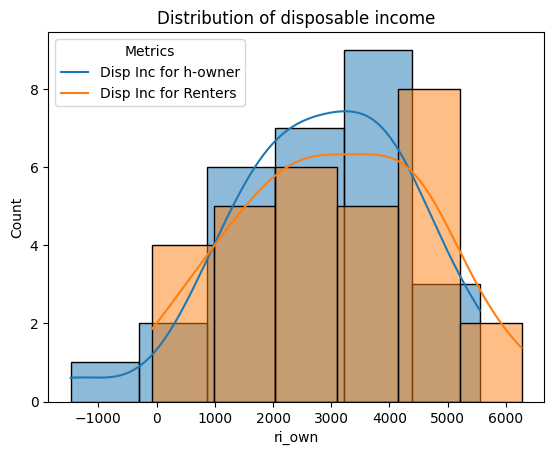

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

#Create histogram of census tracts by disposable income
sns.histplot(monroe_df['ri_own'], kde=True)
sns.histplot(monroe_df['ri_rent'], kde=True)
plt.title('Distribution of disposable income')
plt.legend(title='Metrics', loc='upper left', labels=['Disp Inc for h-owner', 'Disp Inc for Renters'])
plt.show()

This shows that the rough median point of census tracts is around $3000 in disposable income each month. There are 4 census tracts in the under $1000 bucket for renters and about 3 for homeowners. We also see that there are more tracts in the sub $1000 bucket among renters than among homeowners (4 for renters 3 for homeowners.) 

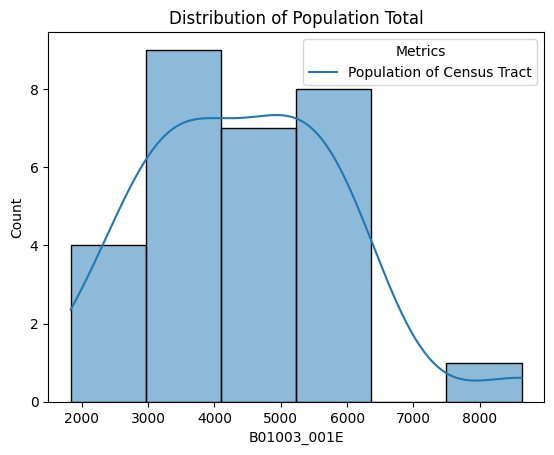

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of census tracts by total population
sns.histplot(mon_merge['B01003_001E'], kde=True)
plt.title('Distribution of Population Total')
plt.legend(title='Metrics', loc='upper right', labels=['Population of Census Tract'])
plt.show()

In order to simplify the visuals, lets create a category that averages the disposable income of renters and owners. We know that there are more tracts with unaffordability issues for renters than homeowners so we'll still need to keep that in mind.

Next, we should look at how many actual individuals fall into the different levels of disposable income. To do this let's create bins of -1000 to 2000, 2K to 3K, 3K to 4K, 4K to 5K and over 5K. Then we can use the population numbers to indicate how many people are living within the census tracks at these average levels. It's important to remember that these are average numbers across the census tracts so we can't say that the number indicates how many individuals are at these disposable income levels, but rather how many people are living in the areas with these average numbers. This should serve our purposes by estimating the areas where the most people are likely to benefit from affordable housing initiatives. 

In [20]:
import plotly.express as px
import pandas as pd

#create bar graph showing population within each bin of disposable income level
bins = [-1000, 2000, 3000, 4000, 5000, float('inf')]  # Define bin edges
labels = ['Negative-2k', '2-3k', '3-4k', '4-5k', '5k+']  # Define bin labels

mon_merge['disp_ave'] = pd.to_numeric(mon_merge['disp_ave'], errors='coerce')
mon_merge['disp_ave'] = mon_merge['disp_ave'].apply(lambda x: max(x, 0)) # Replace negative values with 0
mon_merge2 = mon_merge.dropna(subset=['disp_ave'])

mon_merge2['Disp_Income_Group'] = pd.cut(mon_merge2['disp_ave'], bins=bins, labels=labels, right=False)
grouped_mon_merge = mon_merge2.groupby('Disp_Income_Group')['B01003_001E'].sum().reset_index()

fig = px.bar(grouped_mon_merge, x='Disp_Income_Group', y='B01003_001E', text='B01003_001E',
             labels={'Income_Group': 'Disposable Income Group', 'B01003_001E': 'Total Population'},
             title='Number of Individuals within each Disposable Income Group',
             height=500)

# Customize the layout
fig.update_layout(xaxis=dict(title_text='Disposable Income Group'),
                  yaxis=dict(title_text='Total Population'))


fig.show()


This graph indicates that the largest group of individuals is living in the lowest grouping in terms of the average disposable income per census tract. At this point it would helpful to look at the economic situations in each tract area and we can start to focus in on which areas are most at risk for unaffordable housing.

In [21]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

# Add a bar for population and one for average diposable income
fig.add_trace(go.Bar(x=mon_merge['GEOID'], y=mon_merge['B01003_001E'], name='Population'))

fig.add_trace(go.Bar(x=mon_merge['GEOID'], y=mon_merge['disp_ave'], name='Average Disposable Income'))

fig.update_layout(barmode='group', title='Average Diposable Income and Population by Tract', xaxis_title='Tract', yaxis_title='Values')

fig.show()

Looking at the graphs above, we see each of the tracts that make up Monroe County with their respective population and disposable income amounts indicated by bar height. The 7 tracts circled above will be chosen as the focus areas for our purposes since they clearly have a significant population and low average disposable income after housing costs. We also see a few issues with the data, in tract 100 (18105000100) we don’t show anything for disposable income, this is due to having a negative average disposable income, so this is our worst tract for affordability. In tracts 800, and 1402 we are missing population numbers, and in tract 202 we are missing disposable income, all these missing data issues are due to the data provided by the census missing the values. There could be several possible explanations for this but we were not able to make a determination as to the reason at this time so it may be an issue for future follow-up.

In [22]:
# create a subset of the most at risk tracts
selected_geoids = ['18105000602', '18105000100', '18105000201','18105000601', '18105001600','18105000903','18105000904']

subset_mon_merge = mon_merge[mon_merge['GEOID'].isin(selected_geoids)]
subset_monroe_df = monroe_df[monroe_df['GEOID'].isin(selected_geoids)]

Let's create an estimated number of people at risk for poverty based on our poverty rate number. This will give us a number we can plot along with the other numbers we plotted above.

In [23]:
# calculate the population in poverty from the poverty percentage

subset_mon_merge['est_poverty_pop'] = ((subset_mon_merge['Poverty_Rate']/100)*subset_mon_merge['B01003_001E'])
subset_mon_merge['est_poverty_pop']

0     1134.0
1     2541.0
2       30.0
6     1299.0
16    3418.0
17    1273.0
18    1859.0
Name: est_poverty_pop, dtype: float64

Now let’s create a similar visual with more details about the selected tracts for focus.

In [24]:
import plotly.graph_objects as go
import pandas as pd

# plot population, disposable income for renters and homeowners, and estimated population under poverty line
fig = go.Figure()

fig.add_trace(go.Bar(x=subset_mon_merge['GEOID'], y=subset_mon_merge['B01003_001E'], name='Population'))

fig.add_trace(go.Bar(x=subset_mon_merge['GEOID'], y=subset_mon_merge['ri_rent'], name='Average Disposable Income Renters'))

fig.add_trace(go.Bar(x=subset_mon_merge['GEOID'], y=subset_mon_merge['ri_own'], name='Average Disposable Income Homeowners'))

fig.add_trace(go.Bar(x=subset_mon_merge['GEOID'], y=subset_mon_merge['est_poverty_pop'], name='Estimate number of residents under poverty line'))

fig.update_layout(barmode='group', title='Average Diposable Income and Population by Tract', xaxis_title='Tract', yaxis_title='Values')

fig.show()

This chart helps bring the issue into focus, we see clearly that tract 100 and 600 have noticeably higher resident poverty rates along with lower disposable income levels. This would make these tract ideal areas to target for affordable housing. The other areas are still important to target with the possible exception of tract 201 which despite having a low disposable income estimate for renters, seems to also have very low poverty rates despite a large population. Affordable housing may be an issue in 201 but since poverty rates are low it stands to reason that residents would have capacity to either accept the higher housing costs or relocated to other areas since they don't seem to lack for resources overall. We'll create an updated list level 1 indicating most urgent housing concerns, level 2 being moderately urgent and level 3 being less urgent.

In [25]:
#create subsets by level of housing affordability risk
level1_geoids = ['18105000100', '18105001600']
level2_geoids = ['18105000602', '18105000601','18105000903','18105000904']
level3_geoids = ['18105000201']

level1_monroe_df = monroe_df[monroe_df['GEOID'].isin(level1_geoids)]
level2_monroe_df = monroe_df[monroe_df['GEOID'].isin(level2_geoids)]
level3_monroe_df = monroe_df[monroe_df['GEOID'].isin(level3_geoids)]

In [26]:
from geopy.geocoders import Nominatim

#find the location of Bloomington to center the plot
address = 'Bloomington, IN'

geolocator = Nominatim(user_agent="CN_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bloomington are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bloomington are 39.1670396, -86.5342881.


In [27]:
import plotly.express as px

px.set_mapbox_access_token('pk.eyJ1IjoicGVldmVlNDQiLCJhIjoiY2xwb2pmaTVxMG84aTJxbmpuOTFseWg5NiJ9.l5pZpLYQce5cW7iZyPPX0g')

selected_geoids = subset_monroe_df['GEOID'].tolist()

fig = px.choropleth_mapbox(
    monroe_df,
    geojson=monroe_df.geometry,
    locations=monroe_df.index,
    color='ri_rent',
    range_color=(0, 7000),
    color_continuous_scale="Viridis",
    opacity=0.6,
    labels={'ri_rent': 'Disposable Income'},
    title='Disposable Income for Renters in Monroe County',
    # mapbox_style="carto-positron",  # Use a different mapbox style for more detail
    mapbox_style="open-street-map",
    center={"lat": latitude, "lon": longitude},  # Specify the center of your map
    zoom=10,
)
fig.update_layout(margin={"r": 5, "t": 35, "l": 5, "b": 5},
                    height=800,  
                    width=1200,                 
)

traces = []
for subset, color in zip([level1_monroe_df, level2_monroe_df, level3_monroe_df], ['red', 'blue', 'green']):
    trace = go.Scattermapbox(
        lat=[geom.centroid.y if geom.type == 'Polygon' else geom.centroid.y for geom in subset.geometry],
        lon=[geom.centroid.x if geom.type == 'Polygon' else geom.centroid.x for geom in subset.geometry],
        mode='markers',
        marker=dict(size=10, color=color),  # Adjust marker size and color as needed
        hoverinfo='text',
        text=subset['GEOID'],  # Adjust the column name as needed
    )
    traces.append(trace)

# Add the traces to the figure
for trace in traces:
    fig.add_trace(trace)

# Improve the legend
fig.update_layout(coloraxis_colorbar=dict(
    thicknessmode="pixels", thickness=10,
    lenmode="pixels", len=150,
    yanchor="top", y=0.8,
    ticks="outside",
    dtick=1000
))

fig.show()

In looking over our map it's clear that the areas with the most significant affordable housing concerns are also the areas near Indiana University campus so if we want to also look at what the situation might look like for permanent residents of the county we can recreate the visuals for just homeowners and see if this casts any of the findings in different light.

In [28]:
import plotly.graph_objects as go
import pandas as pd

# create bar plots for disposable income for homeowners and population
fig = go.Figure()

fig.add_trace(go.Bar(x=mon_merge['GEOID'], y=mon_merge['B01003_001E'], name='Population'))

fig.add_trace(go.Bar(x=mon_merge['GEOID'], y=mon_merge['ri_own'], name='Average Disposable Income Homeowners'))

fig.update_layout(barmode='group', title='Average Diposable Income and Population by Tract', xaxis_title='Tract', yaxis_title='Values')

fig.show()

This plot paints a similar picture, it seems that the same roughly 7 tracts are most significant with the possible inclusion of tract 301 which has a bit lower population but does seem to also warrant attention. In the homeowner category tract 100 looks worse than for renters.

In [29]:
#create subset df based on owner data
ho_geoids = ['18105000602', '18105000100', '18105000201','18105000601', '18105001600','18105000903','18105000904','18105000301']

ho_mon_merge = mon_merge[mon_merge['GEOID'].isin(ho_geoids)]
ho_monroe_df = monroe_df[monroe_df['GEOID'].isin(ho_geoids)]

ho_mon_merge['est_poverty_pop'] = ((ho_mon_merge['Poverty_Rate']/100)*ho_mon_merge['B01003_001E'])

In [30]:
import plotly.graph_objects as go
import pandas as pd

#bar plots for various aspects of at risk tracts
fig = go.Figure()

fig.add_trace(go.Bar(x=ho_mon_merge['GEOID'], y=ho_mon_merge['B01003_001E'], name='Population'))

fig.add_trace(go.Bar(x=ho_mon_merge['GEOID'], y=ho_mon_merge['ri_own'], name='Average Disposable Income Homeowners'))

fig.add_trace(go.Bar(x=ho_mon_merge['GEOID'], y=ho_mon_merge['est_poverty_pop'], name='Estimate number of residents under poverty line'))

fig.update_layout(barmode='group', title='Average Diposable Income for Homeowners and Population by Tract', xaxis_title='Tract', yaxis_title='Values')

fig.show()

In [31]:
#create subsets based on risk level
level1_geoids = ['18105000100', '18105001600']
level2_geoids = ['18105000602', '18105000601','18105000903','18105000904','18105000301']
level3_geoids = ['18105000201']

level1_ho_df = monroe_df[monroe_df['GEOID'].isin(level1_geoids)]
level2_ho_df = monroe_df[monroe_df['GEOID'].isin(level2_geoids)]
level3_ho_df = monroe_df[monroe_df['GEOID'].isin(level3_geoids)]

 Updating our data, here is what the map looks like considering only the homeowner data:

In [32]:
import plotly.express as px

px.set_mapbox_access_token('pk.eyJ1IjoicGVldmVlNDQiLCJhIjoiY2xwb2pmaTVxMG84aTJxbmpuOTFseWg5NiJ9.l5pZpLYQce5cW7iZyPPX0g')

selected_geoids = ho_monroe_df['GEOID'].tolist()

fig = px.choropleth_mapbox(
    monroe_df,
    geojson=monroe_df.geometry,
    locations=monroe_df.index,
    color='ri_own',
    range_color=(0, 7000),
    color_continuous_scale="Viridis",
    opacity=0.6,
    labels={'ri_own': 'Disposable Income'},
    title='Disposable Income for Homeowners in Monroe County',
    # mapbox_style="carto-positron",  # Use a different mapbox style for more detail
    mapbox_style="open-street-map",
    center={"lat": latitude, "lon": longitude},  # Specify the center of your map
    zoom=10,
)
fig.update_layout(margin={"r": 5, "t": 35, "l": 5, "b": 5},
                    height=800,  
                    width=1200,                 
)

traces = []
for subset, color in zip([level1_ho_df, level2_ho_df, level3_ho_df], ['red', 'blue', 'green']):
    trace = go.Scattermapbox(
        lat=[geom.centroid.y if geom.type == 'Polygon' else geom.centroid.y for geom in subset.geometry],
        lon=[geom.centroid.x if geom.type == 'Polygon' else geom.centroid.x for geom in subset.geometry],
        mode='markers',
        marker=dict(size=10, color=color),
        hoverinfo='text',
        text=subset['GEOID'],
    )
    traces.append(trace)

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(coloraxis_colorbar=dict(
    thicknessmode="pixels", thickness=10,
    lenmode="pixels", len=150,
    yanchor="top", y=0.8,
    ticks="outside",
    dtick=1000
))

fig.show()

As mentioned earlier one generally accepted measure of housing affordability is that an individual shouldn’t need to spend more than 30 percent of their income per month on housing. Below is an additional map showing census tracts that do not meet this criteria based on average cost of housing as a percentage of average monthly income:

In [33]:

import numpy as np

#create new feature column for percentage of income housing costs and subset data for tracts with average housing costs above 30% of average income.

def calculate_housing_cost(row):
    if not pd.isna(row['median_smoc_mortgage']) and row['median_smoc_mortgage'] != 0:
        return (row['median_gross_rent'] + row['median_smoc_mortgage']) / 2
    else:
        return row['median_gross_rent']

monroe_df['ave_housing_cost'] = monroe_df.apply(calculate_housing_cost, axis=1)

monroe_df['percent_housing'] = monroe_df['ave_housing_cost'] / monroe_df['med_inc_month']

threshold_value = 0.3

above_30_pct= monroe_df[monroe_df['percent_housing'] > threshold_value]
above_30_pct.shape

(11, 19)

In [34]:
import plotly.express as px
import plotly.graph_objects as go


px.set_mapbox_access_token('pk.eyJ1IjoicGVldmVlNDQiLCJhIjoiY2xwb2pmaTVxMG84aTJxbmpuOTFseWg5NiJ9.l5pZpLYQce5cW7iZyPPX0g')

fig = px.choropleth_mapbox(
    monroe_df,
    geojson=monroe_df.geometry,
    locations=monroe_df.index,
    color='disp_ave',
    range_color=(0, 7000),
    color_continuous_scale="Viridis",
    opacity=0.6,
    labels={'ri_own': 'Disposable Income'},
    title='Disposable Income for Homeowners in Monroe County',
    mapbox_style="open-street-map",
    center={"lat": latitude, "lon": longitude},
    zoom=10,
)

# Add a single color marker for the 'above_30_pct' subset
trace = go.Scattermapbox(
    lat=[geom.centroid.y if geom.type == 'Polygon' else geom.centroid.y for geom in above_30_pct.geometry],
    lon=[geom.centroid.x if geom.type == 'Polygon' else geom.centroid.x for geom in above_30_pct.geometry],
    mode='markers',
    marker=dict(size=10, color='orange'),  # Choose your desired color
    hoverinfo='text',
    text=above_30_pct['GEOID'],
)

fig.add_trace(trace)

fig.update_layout(margin={"r": 5, "t": 35, "l": 5, "b": 5},
                  height=800,
                  width=1200,
)

fig.update_layout(coloraxis_colorbar=dict(
    thicknessmode="pixels", thickness=10,
    lenmode="pixels", len=150,
    yanchor="top", y=0.8,
    ticks="outside",
    dtick=1000
))

fig.show()

We can see that much of the city of Bloomington is, on average, living below the 30% threshold, so overall this data tends to support the argument that affordable housing is needed. Focusing on the more central areas of Bloomington with housing relief efforts would seem to be the best target to provide relief to the largest number of residents at-risk. 

In [37]:
cols = mon_merge.columns
cols

Index(['GEOID', 'owner_occupied_hu', 'renter_occupied_hu',
       'pct_renter_occupied_hu', 'median_smoc_mortgage', 'median_gross_rent',
       'median_hh_income', 'area_median_hh_income', 'job_density_simple',
       'job_gravity', 'SHAPE_Length', 'SHAPE_Area', 'geometry',
       'med_inc_month', 'ri_own', 'ri_rent', 'disp_ave', 'NAME', 'C17002_001E',
       'C17002_002E', 'C17002_003E', 'B01003_001E', 'state', 'county', 'tract',
       'Poverty_Rate'],
      dtype='object')

In [38]:
mon_merge.head()

,GEOID,owner_occupied_hu,renter_occupied_hu,pct_renter_occupied_hu,median_smoc_mortgage,median_gross_rent,median_hh_income,area_median_hh_income,job_density_simple,job_gravity,...,disp_ave,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,Poverty_Rate
0,18105000602,314.0,1031.0,76.654275,855.0,769.0,19388.0,43828.0,2.042272,25377.459880,...,803.67,"Census Tract 6.02, Monroe County, Indiana",3334.0,681.0,453.0,3336.0,18,105,000602,33.992806
1,18105000100,100.0,2137.0,95.529727,2420.0,1021.0,11351.0,43828.0,68.793004,37444.922870,...,0.00,"Census Tract 1, Monroe County, Indiana",3476.0,1621.0,920.0,3773.0,18,105,000100,67.346939
2,18105000201,0.0,165.0,100.000000,NaN,684.0,17946.0,43828.0,1.349722,24383.906770,...,811.50,"Census Tract 2.01, Monroe County, Indiana",99.0,20.0,10.0,4862.0,18,105,000201,0.617030
3,18105000901,444.0,663.0,59.891599,1327.0,946.0,40065.0,43828.0,1.693113,19795.311140,...,2202.25,"Census Tract 9.01, Monroe County, Indiana",2786.0,1036.0,305.0,2787.0,18,105,000901,48.116254
4,18105000502,996.0,411.0,29.211087,866.0,762.0,44323.0,43828.0,0.130767,6860.450789,...,2879.58,"Census Tract 5.02, Monroe County, Indiana",3338.0,64.0,204.0,3338.0,18,105,000502,8.028760


The final step of the project, we will create a data dictionary for the compiled dataset.

In [41]:
#data distionary template:

# Customize for data in this project
columns = mon_merge.columns
data_types = mon_merge.dtypes
descriptions = columns
description_lst = [' Geographic ID for the row, is a combination of FIPS code for the state, county and census tract',
                   ' Number of owner occupied housing units in the census tract',
                   ' Number of renter occupied housing units in the census tract',
                   ' Percent of housing units that are occupied by renters',
                   ' Median cost of housing for homeowners with a mortgage',
                   ' Median cost of housing for renters',
                   ' Median household income',
                   ' Median household income for the area (county)',
                   ' Number of jobs divided by total land area',
                   ' Job density that also considers the distance to workplaces',
                   ' Length of the shape for the tract',
                   ' Area of the shape for the tract',
                   ' Geometry for the tract',
                   ' Median household income divided by 12',
                   ' Difference between monthly median income and median cost of housing for homeowners',
                   ' Difference between monthly median income and median cost of housing for renters',
                   ' Average of disposable income for renters and homeowners',
                   ' Name of the census tract',
                   ' NUmber of individuals whose household income is under the poverty line total',
                   ' Number of individuals whose household income is Under .50 of the poverty level',
                   ' Number of individuals whose household income is between .50 and .99 of the poverty level',
                   ' Total population for the census tract',
                   ' state name',
                   ' county name',
                   ' census tract',
                   ' Poverty rate as calculated by the total number of individuals below the poverty line divided by total population']

descriptions = list(map(str.__add__, descriptions, description_lst))

def generate_data_dictionary(column_names, descriptions, data_types):
    data_dictionary = {}

    for column, desc, data_type in zip(column_names, descriptions, data_types):
        data_dictionary[column] = {
            'Description': desc,
            'DataType': data_type,

        }

    return data_dictionary

data_dictionary = generate_data_dictionary(columns, descriptions, data_types)
monroe_housing_dd = data_dictionary
monroe_housing_dd

{'GEOID': {'Description': 'GEOID Geographic ID for the row, is a combination of FIPS code for the state, county and census tract',
  'DataType': dtype('O')},
 'owner_occupied_hu': {'Description': 'owner_occupied_hu Number of owner occupied housing units in the census tract',
  'DataType': dtype('float64')},
 'renter_occupied_hu': {'Description': 'renter_occupied_hu Number of renter occupied housing units in the census tract',
  'DataType': dtype('float64')},
 'pct_renter_occupied_hu': {'Description': 'pct_renter_occupied_hu Percent of housing units that are occupied by renters',
  'DataType': dtype('float64')},
 'median_smoc_mortgage': {'Description': 'median_smoc_mortgage Median cost of housing for homeowners with a mortgage',
  'DataType': dtype('float64')},
 'median_gross_rent': {'Description': 'median_gross_rent Median cost of housing for renters',
  'DataType': dtype('float64')},
 'median_hh_income': {'Description': 'median_hh_income Median household income',
  'DataType': dtype('

In [ ]:
#Export data files to CSV

mon_merge.to_csv(r'./monroe_affordability.csv', index = False)

mc_dd_df = pd.DataFrame.from_dict(monroe_housing_dd) 
mc_dd_df.to_csv(r'./monroe_data_dict.csv', index = False)